### I started by wanting to predict Apparent Temperature, but it so closely follows Temp that you can get 98% accuracy just using that alone.  So, I went for predicting humidity instead.  Humidity is one of the only stats with which Wind Speed is correlated (negatively, about 23%); that allowed me to gain some predictive power, though the kde plot looks pretty terrible in terms of a linear relationship.
### I tried a variety of configurations, and had done a bunch of transformations as well as normalization (all variables normalized from 0 to 1).  Ultimately, I went back and tested without and liked the results!  Also, I tried various levels of cross-validation, and ended at 5.  For my KNN, it was detrimental to use weights, so I kept it uniform.
### As it turned out, the KNN performed better than OLS by about 7%.  10 neighbors worked well.  I'm a pragmatist.  I don't like one model more than the other, and only look at the numbers.  In this case, I'd use the KNN.  Before, when I was predicting Felt Temp, it didn't matter at all, as the difference between them was insignificant statistically.  
### If I wanted to spend more time, I would encode the daily summary and use it to help predict.

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import datetime as dt

from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import linear_model
import statsmodels.formula.api as smf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)
pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline

In [77]:
def normalize(df, col_in):
    """
    Normalize an array of numbers from 0 -> 1
    IN: 1) a dataframe 2) which column to work on
    OUT: normalized dataframe
    EX: df['new_norm'] = normalize(df, 'current')
    """
    
    current = df[col_in]
    return (current - current.min()) / (current.max() - current.min())

    # should you prefer a range from -1 to 1, use the commented out alternative
    #return (current - current.mean()) / (current.max() - current.min())

In [78]:
weather = pd.read_csv("weather_hist.csv")
print(weather.columns)

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')


In [79]:
weather.rename(columns={"Formatted Date":"date", "Summary":"summary", "Precip Type":"precip",
                        "Temperature (C)":"temp", "Apparent Temperature (C)":"apparent_temp",
                        "Humidity":"humidity", "Wind Speed (km/h)":"wind_spd", "Visibility (km)":"vis_km",
                        "Wind Bearing (degrees)":"wind_bearing", "Loud Cover":"cloud_cov",
                        "Pressure (millibars)":"pressure_mb", "Daily Summary":"daily_sum"}, inplace=True)

# I'm dropping a couple that aren't of interest in my analysis
weather.drop(columns=["cloud_cov", "daily_sum"], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


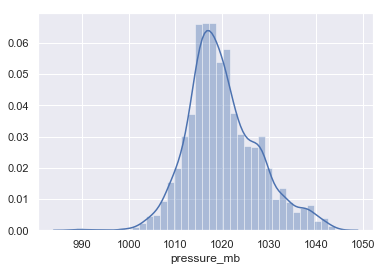

In [173]:
# I used this cell to quickly look at the distributions of variables
# just by switching out the name
x = weather["pressure_mb"]
sns.distplot(x)
plt.show()

In [81]:
# getting rid of outliers and unreasonable values, NaN's
weather.dropna(inplace=True)
weather = weather.loc[(weather["pressure_mb"] > 980) &
                      (weather["wind_spd"] < 40) &
                      (weather["humidity"] > 0.2) &
                      (weather["wind_spd"] > -15) &
                      (weather["pressure_mb"] > 900)]

In [175]:
# converted the dates, though I didn't end up using them
weather["date"] = pd.DatetimeIndex(weather["date"]).date
weather.head(3)

,date,summary,precip,temp,apparent_temp,humidity,wind_spd,wind_bearing,vis_km,pressure_mb
111,2006-04-13,Overcast,rain,9.050,9.050,0.620,0.322,243.000,9.982,1010.000
295,2006-04-20,Foggy,rain,10.161,10.161,0.990,0.338,81.000,0.435,1013.610
356,2006-04-22,Partly Cloudy,rain,15.567,15.567,0.740,0.515,116.000,9.982,1015.040


In [84]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94318 entries, 0 to 96452
Data columns (total 10 columns):
date             94318 non-null object
summary          94318 non-null object
precip           94318 non-null object
temp             94318 non-null float64
apparent_temp    94318 non-null float64
humidity         94318 non-null float64
wind_spd         94318 non-null float64
wind_bearing     94318 non-null float64
vis_km           94318 non-null float64
pressure_mb      94318 non-null float64
dtypes: float64(7), object(3)
memory usage: 7.9+ MB


In [176]:
# have a summary look at only the numerics
wth_nums = weather.loc[:, "temp":]
wth_nums.describe()

,temp,apparent_temp,humidity,wind_spd,wind_bearing,vis_km,pressure_mb
count,1996.000,1996.000,1996.000,1996.000,1996.000,1996.000,1996.000
mean,11.020,11.027,0.824,0.115,67.515,9.412,1020.071
std,8.963,8.981,0.157,0.175,110.211,5.284,7.529
min,-13.889,-13.889,0.210,0.000,0.000,0.000,988.900
25%,4.788,4.788,0.750,0.000,0.000,4.991,1015.118
50%,12.481,12.481,0.870,0.000,0.000,9.982,1018.910
75%,17.706,17.706,0.930,0.209,115.250,15.182,1024.610
max,35.994,37.917,1.000,0.596,356.000,16.100,1043.990


### I ended up not using this rescaling

In [10]:
# rescale everything to between 0 and 1
#for name in wth_nums.columns:
#    weather[name] = normalize(weather, name)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


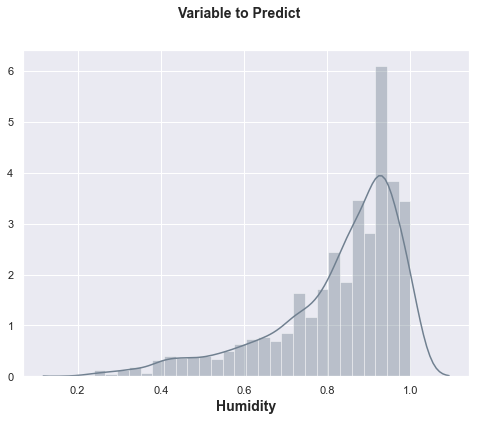

In [179]:
sns.set()
fig, axes = plt.subplots(figsize=(8,6))
fig.suptitle("Variable to Predict", fontsize=14, fontweight='bold')
sns.distplot(weather["humidity"], color='slategrey').set_xlabel("Humidity", fontsize=14, fontweight='bold')

plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


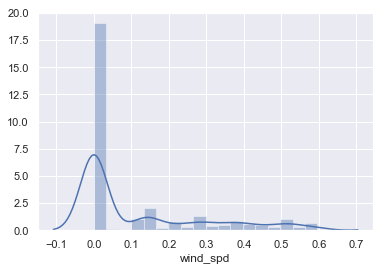

In [180]:
# other outliers above this
weather = weather.loc[weather["wind_spd"] < 0.6]
x = weather["wind_spd"]
sns.distplot(x)
plt.show()

### general look at distributions

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


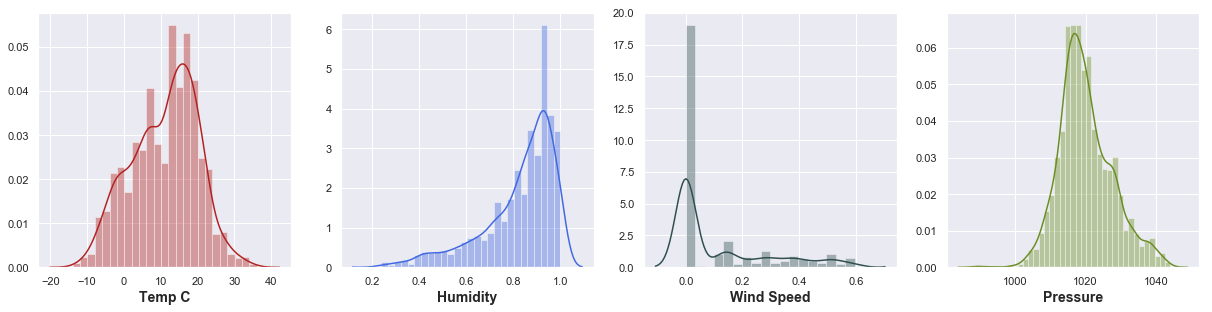

In [88]:
fig, axes = plt.subplots(1, 4, sharex=False, figsize=(17,4.5))

sns.distplot(weather["temp"], ax=axes[0], 
             color='firebrick').set_xlabel("Temp C", fontsize=14, fontweight='bold')
sns.distplot(weather["humidity"], ax=axes[1],
             color='royalblue').set_xlabel("Humidity", fontsize=14, fontweight='bold')
sns.distplot(weather["wind_spd"], ax=axes[2],
             color='darkslategrey').set_xlabel("Wind Speed", fontsize=14, fontweight='bold')
sns.distplot(weather["pressure_mb"], ax=axes[3],
             color='olivedrab').set_xlabel("Pressure", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [89]:
y = weather["apparent_temp"]

### Obviously temp should be that strongly correlated; some nice negative correlation with humidity, and basically nothing at all with wind speed, which surprises me.  A little bit of negative correlation as well with pressure.
### Correction: this reflects my earlier decision to go after apparent temp, but I changed and went for humidity.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


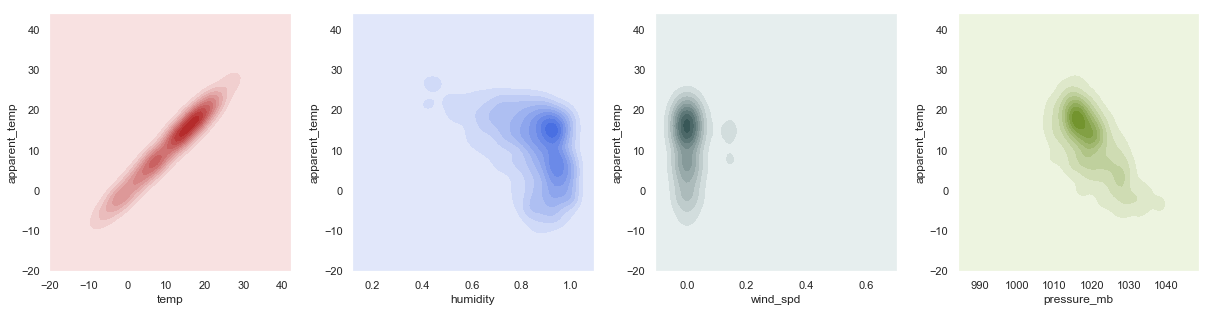

In [90]:
fig, axes = plt.subplots(1, 4, sharex=False, figsize=(17,4.5))

sns.kdeplot(weather["temp"], y, color='firebrick', shade=True, ax=axes[0])
sns.kdeplot(weather["humidity"], y, color='royalblue', shade=True, ax=axes[1])
sns.kdeplot(weather["wind_spd"], y, color='darkslategrey', shade=True, ax=axes[2])
sns.kdeplot(weather["pressure_mb"], y, color='olivedrab', shade=True, ax=axes[3])

plt.tight_layout()
plt.show()

### The relationships above are better (in terms of linearity) than those below, but I'm going for the more difficult ones below.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


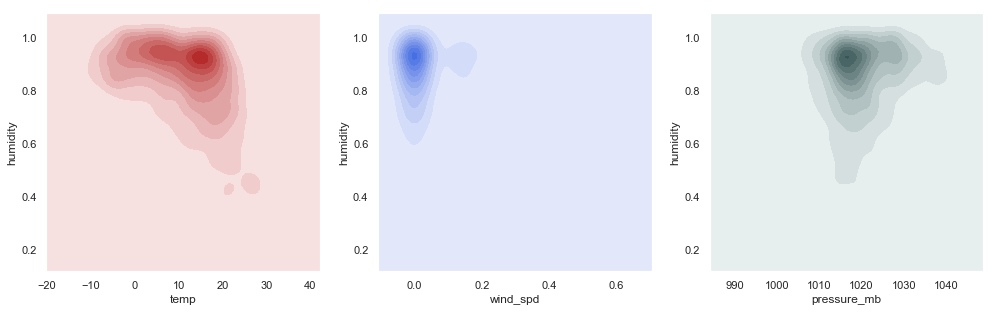

In [181]:
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(14,4.5))
y = weather["humidity"]

sns.kdeplot(weather["temp"], y, color='firebrick', shade=True, ax=axes[0])
sns.kdeplot(weather["wind_spd"], y, color='royalblue', shade=True, ax=axes[1])
sns.kdeplot(weather["pressure_mb"], y, color='darkslategrey', shade=True, ax=axes[2])

plt.tight_layout()
plt.show()

               apparent_temp   temp  humidity  wind_spd  pressure_mb
apparent_temp          1.000  1.000    -0.482     0.053       -0.575
temp                   1.000  1.000    -0.483     0.052       -0.575
humidity              -0.482 -0.483     1.000    -0.233        0.106
wind_spd               0.053  0.052    -0.233     1.000       -0.053
pressure_mb           -0.575 -0.575     0.106    -0.053        1.000


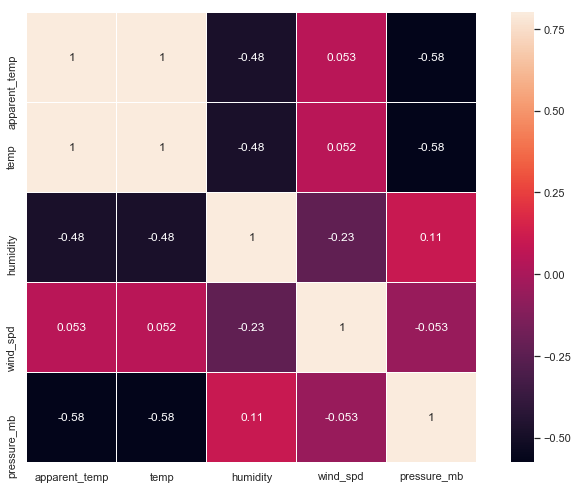

In [127]:
df_corr = weather.loc[:, ["apparent_temp", "temp", "humidity", "wind_spd", "pressure_mb"]]

# Correlation matrix
corrmat = df_corr.corr()
print(corrmat)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, linewidths=0.5)
plt.tight_layout()
plt.show()

### OLS here, you can see some of the other combinations I played with

In [186]:
regr = linear_model.LinearRegression()
Y = weather["humidity"]
#X = weather[["temp", "humidity", "pressure_mb"]]
#X = weather[["temp", "pressure_mb"]]
X = weather[["temp", "pressure_mb", "wind_spd"]]

regr.fit(X, Y)

scores = cross_val_score(regr, X, Y, cv=5)
print(f"Scores across {len(scores)} folds:\n{scores}\nOverall mean: {scores.mean()}")
print(f"Standard deviation: {scores.std():.6}")

Scores across 5 folds:
[0.316615   0.16154055 0.31902649 0.30165689 0.30981646]
Overall mean: 0.28173107763193306
Standard deviation: 0.0603977


### Use statsmodels to get the F-test

In [166]:
#linear_formula = 'apparent_temp ~ temp+humidity+pressure_mb'
linear_formula = 'humidity ~ wind_spd+pressure_mb+temp'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=weather).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.322     
Dependent Variable: humidity         AIC:                -2485.7698
Date:               2018-11-03 17:16 BIC:                -2463.3742
No. Observations:   1996             Log-Likelihood:     1246.9    
Df Model:           3                F-statistic:        316.4     
Df Residuals:       1992             Prob (F-statistic): 5.51e-168 
R-squared:          0.323            Scale:              0.016819  
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept       6.5833    0.4837   13.6105  0.0000   5.6347   7.5319
wind_spd       -0.1923    0.0166  -11.6002  0.0000  -0.2248  -0.1598
pressure_mb    -0.0055    0.0005  -11.6741  0.0000  -0.0064  -0.0046
temp           -0.0109    0.0004  -27.6296  0.0000  -0.0117  -0.0102
-------------------------------------------------------------------
Omnibus:              178.278       Durbin-Watson:          1.075  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       227.536
Skew:                 -0.782        Prob(JB):               0.000  
Kurtosis:             3.541         Condition No.:          169990 
===================================================================
* The condition number is large (2e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

### KNN here

In [171]:
neighs = 10                   # set number of neighbors to use
weigh = "distance"            # set weighting to use

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=neighs, weights='uniform')

knn.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

### I can't find KNN in statsmodels, but I'm pretty sure the above F-test also means I've got some validity with this model too....

In [172]:
score = cross_val_score(knn, X, Y, cv=5)
print(f"Scores across {len(score)} folds:\n{score}\nOverall mean: {score.mean()}")
print(f"Standard deviation: {score.std():.6}")

Scores across 5 folds:
[0.24692161 0.33087921 0.39698005 0.36874345 0.41245497]
Overall mean: 0.35119585832246314
Standard deviation: 0.0590638
